<a href="https://colab.research.google.com/github/acorbin3/07kit/blob/master/ITA_Experiments_isic_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
In this colab we will go over what it takes to generate individual typology angle (ITA) values which were developed in this [paper](https://link.springer.com/chapter/10.1007/978-3-030-59725-2_31?error=cookies_not_supported&code=a61140d1-db8d-4cf8-8d67-a63e1c976380)

The ITA values represent 7 different levels of skin tones

|ITA Range| Skin Tone Category|Abbreviation|
|--|--|--|
|55$^\circ$ $\lt$ ITA|Very Light|very_lt|
|48$^\circ$ $\lt$ ITA $\leq$ 55$^\circ$ |Light 2|lt2|
|41$^\circ$ $\lt$ ITA $\leq$ 48$^\circ$|Light 1|lt1|
|34.5$^\circ$ $\lt$ ITA $\leq$ 41$^\circ$|Intermediate 2|int2|
|28$^\circ$ $\lt$ ITA $\leq$ 34.5$^\circ$|Intermediate 1|int1|
|19$^\circ$ $\lt$ ITA $\leq$ 28$^\circ$|Tanned 2|tan2|
|10$^\circ$ $\lt$ ITA $\leq$ 19$^\circ$|Tanned 1|tan1|
|ITA $\leq$ 10$^\circ$|Dark|dark|

The ITA uses the following equation

ITA$ = archtan \left(\frac{L - 50}{b} \right) \times \frac{180^\circ}{\pi}$

where $L$ is luminance and $b$ is amount of yellow


The main 3 experiments that are going to be covered here are as follows
1. Collect the ITA values of the whole images
2. Collect the ITA values of the cut out potion of the mask from the images
3. Collect the ITA values of ~100 patches around the boarder of the image

These results will then be compared against each other. The masked should be the ground truth since thats removing the skin lesion from the image giving a better representation for the ITA value. Then we will compare the ground truth to the 100 patches to see how well it preformed against the "ground truth"




# Setup & Get images

## Constants 

In [2]:
BORDER_REMOVAL_SIZE = 4
PATCH_WIDTH = 8
PATCH_HEIGHT = 8
PERCENTAGE_OF_RANDOM_PATCHES = .20
PERCENTAGE_OF_RANDOM_PATCHES_NAME = int(PERCENTAGE_OF_RANDOM_PATCHES*100)
TEST_RANDOM_PATCH_PERCENTAGE = False

DATASET_USED = "ISIC_2016" ## options ISIC_2016, ISIC_2017, ISIC_2018

## Installs & Imports

### install

In [3]:
!pip install patchify
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 23.1 MB 1.2 MB/s 


### Imports

In [4]:
import random
import os
import io
import numpy as np 
import pandas as pd 
import seaborn as sns, matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.patches as patches
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, explained_variance_score, mean_squared_log_error
from sklearn.metrics import r2_score, mean_poisson_deviance, mean_gamma_deviance, mean_tweedie_deviance
from sklearn.metrics import confusion_matrix

from patchify import patchify
from pathlib import Path

import tensorflow as tf, re, math
import tensorflow.keras.backend as K

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from skimage.util.shape import view_as_windows
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import skimage
import cv2
from skimage import color


AUTO = tf.data.experimental.AUTOTUNE
random.seed(42)
rng = np.random.default_rng(seed=42)




## Download Images

### ISIC 2016 Task 1 training and test data

In [5]:
if DATASET_USED == "ISIC_2016":
    !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip
    !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Test_Data.zip
    !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_GroundTruth.zip
    !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Test_GroundTruth.zip

--2021-10-05 08:15:00--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.140.188
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.216.140.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 631625308 (602M) [application/zip]
Saving to: ‘ISBI2016_ISIC_Part1_Training_Data.zip’

ISBI2016_ISIC_Part1 100%[===================>] 602.36M  33.4MB/s    in 18s     

2021-10-05 08:15:18 (33.0 MB/s) - ‘ISBI2016_ISIC_Part1_Training_Data.zip’ saved [631625308/631625308]

--2021-10-05 08:15:18--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Test_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.47.124
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.47.124|:443... connected

In [7]:
if DATASET_USED == "ISIC_2016":
    !unzip ISBI2016_ISIC_Part1_Training_Data.zip -d ISIC_2016 > /dev/null.
    !unzip ISBI2016_ISIC_Part1_Test_Data.zip -d ISIC_2016 > /dev/null.
    !unzip ISBI2016_ISIC_Part1_Training_GroundTruth.zip -d ISIC_2016_GT > /dev/null.
    !unzip ISBI2016_ISIC_Part1_Test_GroundTruth.zip -d ISIC_2016_GT > /dev/null.

replace ISIC2016/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
A
replace ISIC2016/ISBI2016_ISIC_Part1_Test_Data/ISIC_0000003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace ISIC2016_GT/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000000_Segmentation.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace ISIC2016_GT/ISBI2016_ISIC_Part1_Test_GroundTruth/ISIC_0000003_Segmentation.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


ISIC2016/ISBI2016_ISIC_Part1_Test_Data/ISIC_0000003.jpg
ISIC2016_GT/ISBI2016_ISIC_Part1_Test_GroundTruth/ISIC_0000003_Segmentation.png
Same size? True 1279


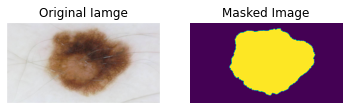

In [10]:
if DATASET_USED == "ISIC_2016":
    # Display both 1 mask and 1 regular file
    index = 0
    files = Path("ISIC_2016").glob("**/*.jpg")
    org = ""
    org_files = []
    for file in files:
        org_files.append(file)
        
    org_files.sort()
    print(org_files[index])
    org = Image.open(org_files[index])
        
    gt_files = Path("ISIC_2016_GT").glob("**/*.png")
    gt = ""
    gt_files_list = []
    for file in gt_files:
        gt_files_list.append(file)
        
    gt_files_list.sort()    
    print(gt_files_list[index])
    gt = Image.open(gt_files_list[index])

    ax = plt.subplot(1, 2, 1)

    plt.imshow(org,aspect=.7)
    plt.title("Original Iamge")
    plt.axis("off")
    plt.subplots_adjust(hspace = .5)

    ax = plt.subplot(1, 2,2)

    plt.imshow(gt,aspect=.7)
    plt.title("Masked Image")
    plt.axis("off")
    plt.subplots_adjust(hspace = .5)

    print(f"Same size? {len(org_files) == len(gt_files_list)} {len(org_files)}")

### ISIC 2017 dataset
This includes the training, validation, and test data resised to 192 x 256. 

In [ ]:
if DATASET_USED == "ISIC_2017":
    !git clone https://github.com/manideep2510/melanoma_segmentation.git

Cloning into 'melanoma_segmentation'...
remote: Enumerating objects: 5578, done.
remote: Total 5578 (delta 0), reused 0 (delta 0), pack-reused 5578
Receiving objects: 100% (5578/5578), 101.46 MiB | 32.20 MiB/s, done.
Resolving deltas: 100% (464/464), done.


### ISIC 2018
https://challenge.isic-archive.com/data

In [ ]:
if DATASET_USED == "ISIC_2018":
    !wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip
    !wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip

In [ ]:
if DATASET_USED == "ISIC_2018":
    !unzip ISIC2018_Task1-2_Training_Input.zip -d ISIC_2018 > /dev/null.
    !unzip ISIC2018_Task1_Training_GroundTruth.zip -d ISIC_2018_GT > /dev/null.

# Organize images into a dataset

## Read all images from test, train and validation

In [11]:
"""
This section we read all the images including their masks. 
"""

orig_images = []
masks_images = []

if DATASET_USED == "ISIC_2016":
    for file in Path("ISIC_2016").glob("**/*.jpg"):        
        orig_images.append(file)

    for file in Path("ISIC_2016_GT").glob("**/*.png"):
        masks_images.append(file)

if DATASET_USED == "ISIC_2017":
    """ Since we are just using this to test the ITA values we can join 
        the test, train and validation sets
    """
    folders_to_search = ["test","train","validation"]
    for folder in folders_to_search:
        for file in Path(f"melanoma_segmentation/{folder}x").glob("*.jpg"):        
            orig_images.append(file)

        for file in Path(f"melanoma_segmentation/{folder}y").glob("*.jpg"):
            masks_images.append(file)

if DATASET_USED == "ISIC_2018":
    for file in Path("ISIC_2018").glob("**/*.jpg"):        
        orig_images.append(file)

    for file in Path("ISIC_2018_GT").glob("**/*.png"):
        masks_images.append(file)

print(len(orig_images))
print(len(masks_images))


1279
1279


In [ ]:
def strip_filename(file):
    """
    This function makes an identifier that matches between both the base image and the masked image
    """
    # Cleaning files names here: https://github.com/manideep2510/melanoma_segmentation.git
    fn = file.name.replace("imgx","")
    fn = fn.replace("imgy","")
    path = file.parent.parts[-1].replace("x","").replace("y","")

    # Cleaning ISIC 2016 filenames
    fn = file.name.replace("_Segmentation","").replace(".jpg","").replace(".png","")
    path = file.parent.parts[-1].replace("_Data","").replace("_GroundTruth","")
    
    uuid = f"{path}/{fn}"
    return uuid

In [ ]:
def create_masked_image(image, mask):
    """
    This function takes in an image and mask in bytes. Since the mask is intended to be used to selecte the
    skin leison we need to invert the mask so we can remove the skin leison. Once invert, the mask is applied the
    origional image and then the new masked_image is return as a byte array.
    """
    
    orig_image = Image.open(io.BytesIO(image))
    imgpx = np.array(orig_image)

    mask_bytes = io.BytesIO(mask)
    mask = Image.open(mask_bytes)
    mask = ImageOps.invert(mask) # need to invert the mask because we want to only remove the skin lesion 
    mask_pix = np.array(mask)    

    # Adding the mask to the image 
    image_masked = np.where(mask_pix[...,None], imgpx,0)
    im_byte_array = Image.fromarray(image_masked)

    # Saving the masked image to a byte array
    img_byte_arr = io.BytesIO()
    orig_image = im_byte_array.convert('RGB')
    orig_image.save(img_byte_arr, format="JPEG")
    img_byte_arr = img_byte_arr.getvalue()
    return img_byte_arr

## Create dataframe with images and masks

In [ ]:
dict_data

In [ ]:
dict_data = {}
data_list = []
for file in orig_images:    
    dict_data[strip_filename(file)] = file

for file in masks_images:
    
    # Adding the previous image to the new item so it will include both mask and iamge    
    image = open(dict_data[strip_filename(file)],"rb").read()    
    mask = open(file,"rb").read()

    # now to cut the mask out of the image
    masked_image = create_masked_image(image, mask)
    data_list.append([strip_filename(file), image, mask, masked_image ])
    

# now to create the dataframe
df = pd.DataFrame(data=data_list, columns=["ID","image", "mask", "masked_image"])



### Display dataframe item and images

Sample just 1 image to display the origional and origional with the masked leasion removed. 

ID                      ISBI2016_ISIC_Part1_Training/ISIC_0000155
image           b'\xff\xd8\xff\xdb\x00\x84\x00\x02\x02\x02\x02...
mask            b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
masked_image    b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
Name: 5, dtype: object
Shape of image:  (1536, 2048, 3)


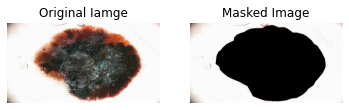

In [ ]:
index = 5
item = df.iloc[index] 
print(item)
mask = item["mask"]
image = item["image"]
img = io.BytesIO(mask)
mask = Image.open(img)
mask = ImageOps.invert(mask) # need to invert the mask because we want to only remove the skin lesion 

orig_image = Image.open(io.BytesIO(image))
pix = np.array(mask)
imgpx = np.array(orig_image)
image_masked = np.where(pix[...,None], imgpx,0)
print("Shape of image: ", imgpx.shape)

im = Image.fromarray(image_masked)


ax = plt.subplot(1, 2, 1)
image = Image.open(io.BytesIO(item["image"]))
plt.imshow(image,aspect=.7)
plt.title("Original Iamge")
plt.axis("off")
plt.subplots_adjust(hspace = .5)

ax = plt.subplot(1, 2,2)
image = Image.open(io.BytesIO(item["masked_image"]))
plt.imshow(image,aspect=.7)
plt.title("Masked Image")
plt.axis("off")
plt.subplots_adjust(hspace = .5)


# ITA experiments

## Compute the ITA value for each image

This section is a simple ITA computation on the images that are masked and unmasked

In [ ]:
def compute_ita_from_lab(lab):
    # get the luminance and b values wihtin +- 1 std from mean
    l = lab[:,:,0]
    l = np.where(l != 0, l, np.nan)
    std = np.nanstd(l)
    mean = np.nanmean(l)
    
    l = np.where(l >= mean - std, l, np.nan)
    l = np.where(l <= mean + std, l, np.nan)
        
    b = lab[:,:,2]
    std = np.nanstd(b)
    mean = np.nanmean(b)
    b = np.where(b >= mean - std, b, np.nan)
    b = np.where(b <= mean + std, b, np.nan)


    ita = math.atan2(np.nanmean(l) - 50, np.nanmean(b)) * (180 / np.pi)
    return ita

In [ ]:
def compute_ita(image):
    img = io.BytesIO(image)
    pilimae = Image.open(img)        
    lab = np.array(skimage.color.rgb2lab(pilimae))
    return compute_ita_from_lab(lab)


In [ ]:
df["ITA_masked"] = df["masked_image"].apply(compute_ita)
df["ITA_orig"] = df["image"].apply(compute_ita)

##Patches experiments

 ### Utils

#### Creating patches from an image
Later on there will be processing to select the individual patches based on the tecnique

In [ ]:
def format_image_and_get_patches(image):
    img = io.BytesIO(image)
    pil_image = Image.open(img) 

    # Crop image to remove the pixels from the boarder
    w, h = pil_image.size
    
    cropped_area = (BORDER_REMOVAL_SIZE,BORDER_REMOVAL_SIZE,w - BORDER_REMOVAL_SIZE, h - BORDER_REMOVAL_SIZE)
    cropped_image = pil_image.crop(cropped_area)


    #print("pil_image", np.array(pil_image).shape)
    #print("cropped_image", np.array(cropped_image).shape)
    # Convert image to lab values
    lab = np.array(skimage.color.rgb2lab(cropped_image))

    # Get the patches
    return patchify(lab, (PATCH_WIDTH,PATCH_HEIGHT,3), step=8)

#### Display 1 image with the selected patches

In [ ]:
def display_single_image_and_selected_patches(image_in_bytes, selected_coords):
    img = io.BytesIO(image_in_bytes)

    im = Image.open(img)

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(im)

    for coord in selected_coords:
        # Create a Rectangle patch    
        x = coord[0] * PATCH_WIDTH + BORDER_REMOVAL_SIZE
        y = int(coord[1] * PATCH_WIDTH) + BORDER_REMOVAL_SIZE    
        rect = patches.Rectangle((y, x), PATCH_HEIGHT, PATCH_WIDTH, linewidth=1, edgecolor='b', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

### ITA on all patches
This section will get the ITA value for all patches within a given image

In [ ]:
def get_ita_for_all_patches(image):
    patches = format_image_and_get_patches(image)
    # Capture all the ITA values for each patch. 
    ita_values = []
    indices = []
    for x, x_item in enumerate(patches):
        for y, y_item in enumerate(patches[x]):        
            patch = patches[x][y][0]        
            ita_values.append(compute_ita_from_lab(patch))  
            indices.append([x,y])
    return ita_values, indices

#### Test 1 image

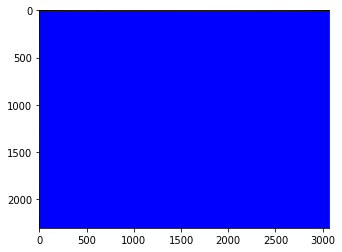

In [ ]:
full_image_ita, full_image_coords = get_ita_for_all_patches(df.iloc[0]["image"])
display_single_image_and_selected_patches(df.iloc[0]["image"],full_image_coords)

### Cropped center

In [ ]:
def get_cropped_center_patches_ita_list(image, verbose=False):
    """
    For the structure patches approach the first row, the last row, first column and last column will be 
    sampled for the ITA values.
    """
    """
    Note we want to ignore the center part of the images. We will take 15% around the center of the image and ignore getting the ITA
    values for those images. Taking 15% of the width and height will get offset value. Then dividing the width and height by 2
    will be the mid-point which we can take the offset and do a +- to get a range where we dont want to capture the ITA values
    as long as the x and y indexes dont fall between both ranges then we will capture the ITA values of the image.

    """
    patches = format_image_and_get_patches(image)

    center_removal_percentage = .70/2
    w = len(patches)
    h = len(patches[0])

    w_offset = math.floor(w * center_removal_percentage)
    h_offset = math.floor(h * center_removal_percentage)

    w_mid = int(w/2)
    h_mid = int(h/2)

    indices = []

    if verbose:
        print("Will ignore values in these ranges")
        print("center_removal_percentage",center_removal_percentage)
        print("w",w)
        print("h",h)
        print("w_offset",w_offset)
        print("h_offset",h_offset)
        print("w_mid",w_mid)
        print("h_mid",h_mid)
        w_range = (w_mid + w_offset) - (w_mid - w_offset)
        print(f"w range diff {w_range} : % {w_range/w}")
        h_range = (h_mid + h_offset) - (h_mid - h_offset)
        print(f"h range diff {h_range} : %{h_range/h}")
        print(f"{w_mid - w_offset} <= x <= {w_mid + w_offset} and {h_mid - h_offset} <= y <= {h_mid + h_offset}")
    selected_ita_values = []
    for x, x_item in enumerate(patches):
        for y, y_item in enumerate(patches[x]):
            if w_mid - w_offset <= x <= w_mid + w_offset and h_mid - h_offset <= y <= h_mid + h_offset:
                continue
            patch = patches[x][y][0]        
            selected_ita_values.append(compute_ita_from_lab(patch)) 
            indices.append([x,y])
    
    return selected_ita_values, indices

In [ ]:
def get_cropped_center_ita(row):
    image = row["image"]
    ita_values, indices = get_cropped_center_patches_ita_list(image)
    row["ITA_center_cropped_all"] = ita_values
    row["ITA_center_cropped"] = np.median(ita_values)
    row["ITA_center_cropped_indices"] = indices
    return row 

#### Test 1 image

Will ignore values in these ranges
center_removal_percentage 0.35
w 287
h 383
w_offset 100
h_offset 134
w_mid 143
h_mid 191
w range diff 200 : % 0.6968641114982579
h range diff 268 : %0.6997389033942559
43 <= x <= 243 and 57 <= y <= 325


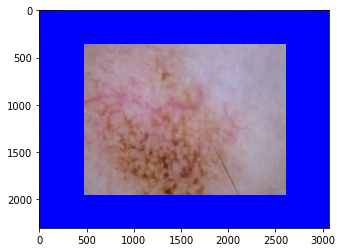

55852 109921 0.5081103701749439


In [ ]:
ita, cropped_center_coords = get_cropped_center_patches_ita_list(df.iloc[0]["image"], verbose=True)
display_single_image_and_selected_patches(df.iloc[0]["image"],cropped_center_coords)
print(len(cropped_center_coords), len(full_image_coords), len(cropped_center_coords)/ len(full_image_coords))

### Structured Patches

Creating masks can be difficult to obtain from either working with medical professionals to generate the masks or even developing an AI segmentation solution to generate the masks. In this alternate approach the idea would be to take small patches around the boarder of the image. The center of the image will not be sampled as we are assuming that skin lesion will be around that potion of the image. Also the absolute boarder will be also ignored with an assumption that there might be some bad artifacts around the boarder that would not represent the skin tones.

In [ ]:
def get_structured_patches_ita_list(image):
    """
    For the structure patches approach the first row, the last row, first column and last column will be 
    sampled for the ITA values. When taking the boarder we need ot make sure the corners are not double counted
    """
    patches = format_image_and_get_patches(image)

    selected_ita_values = []

    row_count = len(patches)
    col_count = len(patches[0])
    

    indices = []
    # First row
    for i, patch in enumerate(patches[0]):        
        selected_ita_values.append(compute_ita_from_lab(patch[0])) 
        indices.append([0,i])
    # last row
    for i, patch in enumerate(patches[-1]):        
        selected_ita_values.append(compute_ita_from_lab(patch[0])) 
        indices.append([row_count - 1,i])
    # First column
    # Not index zero and last index is a corner and already accounted for on the rows
    for i in range(1,row_count - 1):
        patch = patches[i][0]
        selected_ita_values.append(compute_ita_from_lab(patch[0])) 
        indices.append([i,0])

    # Last column
    # Not index zero and last index is a corner and already accounted for on the rows
    for i in range(1,row_count - 1):
        patch = patches[i][-1]
        selected_ita_values.append(compute_ita_from_lab(patch[0]))
        indices.append([i,col_count-1])


    return selected_ita_values, indices

In [ ]:
def get_structured_patches_ita(row):
    """
    This function is intended to add the ITA represented value dataframe for an instance. 
    Its intended to be used with the df.apply() method
    """
    image = row["image"]
    ita_values, indices = get_structured_patches_ita_list(image)
    row["ITA_structured_patches_all"] = ita_values
    row["ITA_structured_patches"] = np.median(ita_values)
    row["ITA_structured_patches_indices"] = indices

    return row

#### Testing 1 image

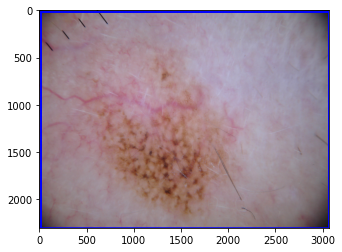

In [ ]:
ita, coords = get_structured_patches_ita_list(df.iloc[0]["image"])
display_single_image_and_selected_patches(df.iloc[0]["image"],coords)

### Random patches

In [ ]:
# randomly pick numbers between 0 and max patches
def get_random_patches_ita_list(image,percentage=PERCENTAGE_OF_RANDOM_PATCHES, verbose=False):
    """
    The premise behind random patches is that a set of patches that do not overlap a generated and at random patches 
    be sampled to take the ITA value from. The thought would be that because its a random sample that the majority should
    cover or represent the skin tone. It is possible that some of the patches could cover a skin lesion which will be address in 
    a future approach.
    """
    patches = format_image_and_get_patches(image)
    row_count = len(patches)
    column_count = len(patches[0])
    
    patch_count = row_count * column_count
    
    random_to_select = int(patch_count * percentage)
    
    # Generate a random list of numbers with no duplicates
    random_patch_indexes = rng.choice(patch_count, size=random_to_select, replace=False)
    random_patch_indexes.sort()
    
    # get reverse indexes. The index number comes from nRow * col_count + nCol. 
    # so for example if you have 10x10 image. image index 23 is row 2 col 4. The formula would be 2*10 + 4 = 24
    # x = number % column_count
    # y = int(number / column_count) 
    
    coordinate_indices = []
    for index in random_patch_indexes:
        y = index % column_count
        x = int(index /column_count)
        coordinate_indices.append([x,y])
    if verbose:
        print(f"row_count {row_count} column_count {column_count} ")
        print(f"patch_count {patch_count}, random_to_select {random_to_select}")
        print(f"random_patch_indexes\n{random_patch_indexes}")
        print(f"coordinate_indices\n{coordinate_indices}")

    ita_values = []
    for index in coordinate_indices:
        x = index[1]
        y = index[0]
        patch = patches[y][x]
        ita_values.append(compute_ita_from_lab(patch[0]))
    return ita_values, coordinate_indices



In [ ]:
def get_random_patches_ita(row,percentage=PERCENTAGE_OF_RANDOM_PATCHES):
    """
    This function is intended to add the ITA represented value dataframe for an instance. 
    Its intended to be used with the df.apply() method
    """

    image = row["image"]
    
    ita_values, indices = get_random_patches_ita_list(image, percentage)
    row[f"ITA_random_patches_{int(percentage*100)}_all"] = ita_values
    row[f"ITA_random_patches_{int(percentage*100)}"] = np.median(ita_values)
    row[f"ITA_random_patches_{int(percentage*100)}_indices"] = indices
    return row

#### Testing 1 image

row_count 287 column_count 383 
patch_count 109921, random_to_select 21984
random_patch_indexes
[     0      1     29 ... 109910 109916 109920]
coordinate_indices
[[0, 0], [0, 1], [0, 29], [0, 31], [0, 35], [0, 40], [0, 42], [0, 43], [0, 51], [0, 55], [0, 60], [0, 65], [0, 66], [0, 85], [0, 87], [0, 91], [0, 93], [0, 102], [0, 103], [0, 114], [0, 122], [0, 123], [0, 127], [0, 133], [0, 134], [0, 138], [0, 156], [0, 162], [0, 164], [0, 166], [0, 173], [0, 176], [0, 179], [0, 180], [0, 187], [0, 191], [0, 197], [0, 201], [0, 212], [0, 224], [0, 225], [0, 234], [0, 235], [0, 244], [0, 246], [0, 247], [0, 249], [0, 255], [0, 262], [0, 270], [0, 273], [0, 277], [0, 282], [0, 288], [0, 294], [0, 300], [0, 302], [0, 307], [0, 310], [0, 315], [0, 318], [0, 319], [0, 328], [0, 329], [0, 330], [0, 332], [0, 333], [0, 336], [0, 338], [0, 343], [0, 351], [0, 353], [0, 364], [0, 371], [0, 373], [0, 374], [1, 2], [1, 17], [1, 24], [1, 28], [1, 36], [1, 43], [1, 48], [1, 51], [1, 54], [1, 58], [1, 59

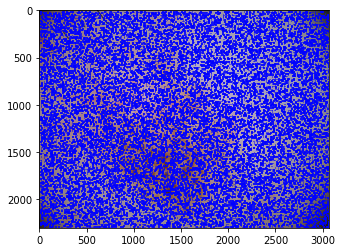

In [ ]:
ita, coords = get_random_patches_ita_list(df.iloc[0]["image"],verbose=True)
display_single_image_and_selected_patches(df.iloc[0]["image"],coords)

#### Showing Random 100%

row_count 287 column_count 383 
patch_count 109921, random_to_select 109921
random_patch_indexes
[     0      1      2 ... 109918 109919 109920]
coordinate_indices
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [0, 12], [0, 13], [0, 14], [0, 15], [0, 16], [0, 17], [0, 18], [0, 19], [0, 20], [0, 21], [0, 22], [0, 23], [0, 24], [0, 25], [0, 26], [0, 27], [0, 28], [0, 29], [0, 30], [0, 31], [0, 32], [0, 33], [0, 34], [0, 35], [0, 36], [0, 37], [0, 38], [0, 39], [0, 40], [0, 41], [0, 42], [0, 43], [0, 44], [0, 45], [0, 46], [0, 47], [0, 48], [0, 49], [0, 50], [0, 51], [0, 52], [0, 53], [0, 54], [0, 55], [0, 56], [0, 57], [0, 58], [0, 59], [0, 60], [0, 61], [0, 62], [0, 63], [0, 64], [0, 65], [0, 66], [0, 67], [0, 68], [0, 69], [0, 70], [0, 71], [0, 72], [0, 73], [0, 74], [0, 75], [0, 76], [0, 77], [0, 78], [0, 79], [0, 80], [0, 81], [0, 82], [0, 83], [0, 84], [0, 85], [0, 86], [0, 87], [0, 88], [0, 89], [0, 90], [0, 91], [0, 92], [0, 93],

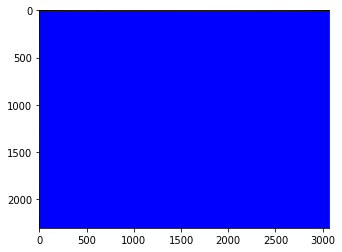

In [ ]:
ita_random_100, coords_random_100 = get_random_patches_ita_list(df.iloc[0]["image"],percentage=1,verbose=True)
display_single_image_and_selected_patches(df.iloc[0]["image"],coords_random_100)

#### Compare Random 100% vs all patches 
Test using the rMSE and MAE between both the full image and random 100%. If they were any different there would have a value greater than 0

In [ ]:
rmse = mean_squared_error(full_image_ita, ita_random_100, squared=False)
mae = mean_absolute_error(full_image_ita, ita_random_100)
print("rmse",rmse)
print("mae",mae)


rmse 0.0
mae 0.0


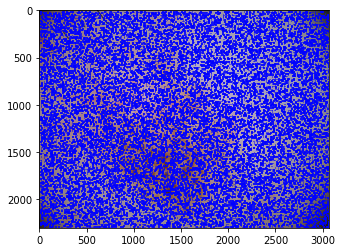

In [ ]:
# display image, 
# add rectangles on each of the patches

img = io.BytesIO(df.iloc[0]["image"])

im = Image.open(img)

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

for coord in coords:
    # Create a Rectangle patch    
    x = coord[0] * PATCH_WIDTH + BORDER_REMOVAL_SIZE
    y = int(coord[1] * PATCH_WIDTH) + BORDER_REMOVAL_SIZE
    rect = patches.Rectangle((y, x), PATCH_HEIGHT, PATCH_WIDTH, linewidth=1, edgecolor='b', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

#### Test Random Patch percentage
The idea here is to check and see if different percentages work better than others. Starting from 5 percent to 100%

In [ ]:
if TEST_RANDOM_PATCH_PERCENTAGE:
    df_percent  = pd.DataFrame()
    columns_to_test = ["ITA_orig"]
    results = []
    for percent in range(5,101,5):
        col = f"ITA_random_patches_{percent}"
        columns_to_test.append(col)
        # df_percent[f"percent_{percent}"]
        df_percent = df.apply(get_random_patches_ita, percentage=percent/100,axis=1)
        res = f"{col} {compute_metrics(df_percent,col)}"
        results.append(res)
        print(res)
    
    for res in results:
        print(results)
        
    

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


ITA_random_patches_5 {'Root Mean Squared Error': 22.644068119396845, 'Mean Absolute Error': 9.433725404146573, 'Max error': 295.34283795198667, 'Mean Squared Error': 512.7538209958846, 'Explained Variance Score': 0.5116493813766296, 'R^2 Score': 0.4665957747335927}


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


ITA_random_patches_10 {'Root Mean Squared Error': 21.517008523395074, 'Mean Absolute Error': 8.947842487466325, 'Max error': 158.57299716134094, 'Mean Squared Error': 462.9816557958562, 'Explained Variance Score': 0.5665311433693841, 'R^2 Score': 0.5182531908526522}


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


ITA_random_patches_15 {'Root Mean Squared Error': 21.506358967855427, 'Mean Absolute Error': 8.846049598928758, 'Max error': 202.0117662354209, 'Mean Squared Error': 462.5234760542555, 'Explained Variance Score': 0.5653247491299809, 'R^2 Score': 0.5185923546519003}


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


ITA_random_patches_20 {'Root Mean Squared Error': 21.853179995033013, 'Mean Absolute Error': 8.857193037321805, 'Max error': 266.78169215557216, 'Mean Squared Error': 477.56147589531105, 'Explained Variance Score': 0.547916929490478, 'R^2 Score': 0.5029403748735195}


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


ITA_random_patches_25 {'Root Mean Squared Error': 21.740403670052697, 'Mean Absolute Error': 8.74870893140257, 'Max error': 274.26924368171564, 'Mean Squared Error': 472.6451517368408, 'Explained Variance Score': 0.5482075182651247, 'R^2 Score': 0.5031824540447969}


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


ITA_random_patches_30 {'Root Mean Squared Error': 21.940985036962108, 'Mean Absolute Error': 8.77365406080374, 'Max error': 274.7889267498498, 'Mean Squared Error': 481.40682439219506, 'Explained Variance Score': 0.5423855532015973, 'R^2 Score': 0.499061289223536}


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


ITA_random_patches_35 {'Root Mean Squared Error': 21.977407915876498, 'Mean Absolute Error': 8.803526885764086, 'Max error': 272.2413843180926, 'Mean Squared Error': 483.00645870083093, 'Explained Variance Score': 0.5409097793099651, 'R^2 Score': 0.497396753725325}


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


ITA_random_patches_40 {'Root Mean Squared Error': 21.71747887437951, 'Mean Absolute Error': 8.72111700741218, 'Max error': 275.81332931064196, 'Mean Squared Error': 471.64888865912025, 'Explained Variance Score': 0.5534538038478345, 'R^2 Score': 0.5090766748334936}


### Smart Random patches

In [ ]:
percent_of_random_patches = .20
# Randomly pick a patch and test using a fitness test


### Evaluating 1 image

In [ ]:
orig_ita_values = get_ita_for_all_patches(df.iloc[0]["image"])[0]
cropped_center_values = get_cropped_center_patches_ita_list(df.iloc[0]["image"])[0]
structured_ita_values = get_structured_patches_ita_list(df.iloc[0]["image"])[0]
random_ita_values = get_random_patches_ita_list(df.iloc[0]["image"])[0]

In [ ]:
print('displaying the number of patches per method')
print(f"|{'Method':20}|{'Count':^10}|{'Total %':^4}|")
print(f"|{'All patches':20}|{len(orig_ita_values):^10}|{len(orig_ita_values)/len(orig_ita_values)*100:^3.3f}|")
print(f"|{'Cropped Center':20}|{len(cropped_center_values):^10}|{len(cropped_center_values)/len(orig_ita_values)*100:^3.3f}|")
print(f"|{'Structured Patches':20}|{len(structured_ita_values):^10}|{len(structured_ita_values)/len(orig_ita_values)*100:^3.3f}|")
print(f"|{'Random Patches':20}|{len(random_ita_values):^10}|{len(random_ita_values)/len(orig_ita_values)*100:^3.3f}|")


displaying the number of patches per method
|Method              |  Count   |Total %|
|All patches         |  109921  |100.000|
|Cropped Center      |  55852   |50.811|
|Structured Patches  |   1336   |1.215|
|Random Patches      |  21984   |20.000|


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

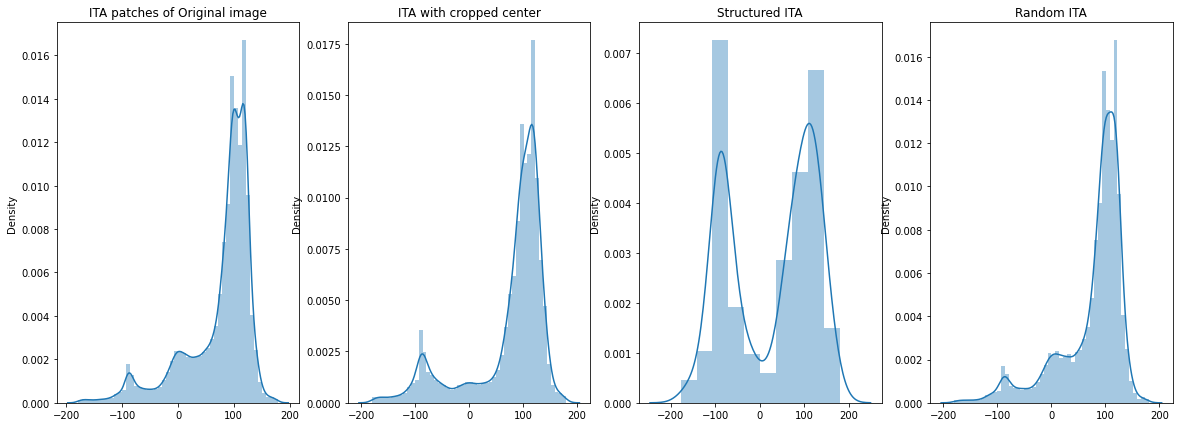

In [ ]:
f, axes = plt.subplots(1, 4)
f.set_size_inches(20,7)


ax = sns.distplot(orig_ita_values,ax=axes[0]).set_title("ITA patches of Original image")
#TODO Add masked 
#ax = sns.distplot(orig_ita_values,ax=axes[0]).set_title("ITA patches of Original image")
ax = sns.distplot(cropped_center_values,ax=axes[1]).set_title("ITA with cropped center")
ax = sns.distplot(structured_ita_values,ax=axes[2]).set_title("Structured ITA")
ax = sns.distplot(random_ita_values,ax=axes[3]).set_title("Random ITA")

## Calculate ITA on all images using following methods

1. Cropped center
2. Structured approach
3. Random patches
4. Smart Random

In [ ]:
df = df.apply(get_cropped_center_ita, axis=1)
df = df.apply(get_structured_patches_ita, axis=1)
df = df.apply(get_random_patches_ita, axis=1)

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


## Add the ITA category to the dataframe

In [ ]:
def add_ita_category(ita):
    if ita <= 10:
        return "dark"
    elif 10 < ita <= 19:
        return "tan1"
    elif 19 < ita <= 28:
        return "tan2"
    elif 28 < ita <= 34.5:
        return "int1"
    elif 34.5 < ita <= 41:
        return "int2"
    elif 41 < ita <= 48:
        return "lt1"
    elif 48 < ita <= 55:
        return "lt2"
    elif 55 < ita:
        return "very_lt"

In [ ]:
df["ITA_orig_category"] = df["ITA_orig"].apply(add_ita_category)
df["ITA_masked_category"] = df["ITA_masked"].apply(add_ita_category)
df["ITA_center_cropped_category"] = df["ITA_center_cropped"].apply(add_ita_category)
df["ITA_structured_patches_category"] = df["ITA_structured_patches"].apply(add_ita_category)
df[f"ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}_category"] = df[f"ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}"].apply(add_ita_category)


# Display images with ITA values along with Lab values

This initial display of images was to get a rough feel to see how the ITA values aligned up with a small sample of images. The ITA values seem to do a decent job a representing the skin tones but there ware a few that seem off such as row 0 col 3. This image is classified as a dark skin tone with an ITA value of 8.56. I think the subject of the image is swinging the ITA value lower than if it was segmented out.

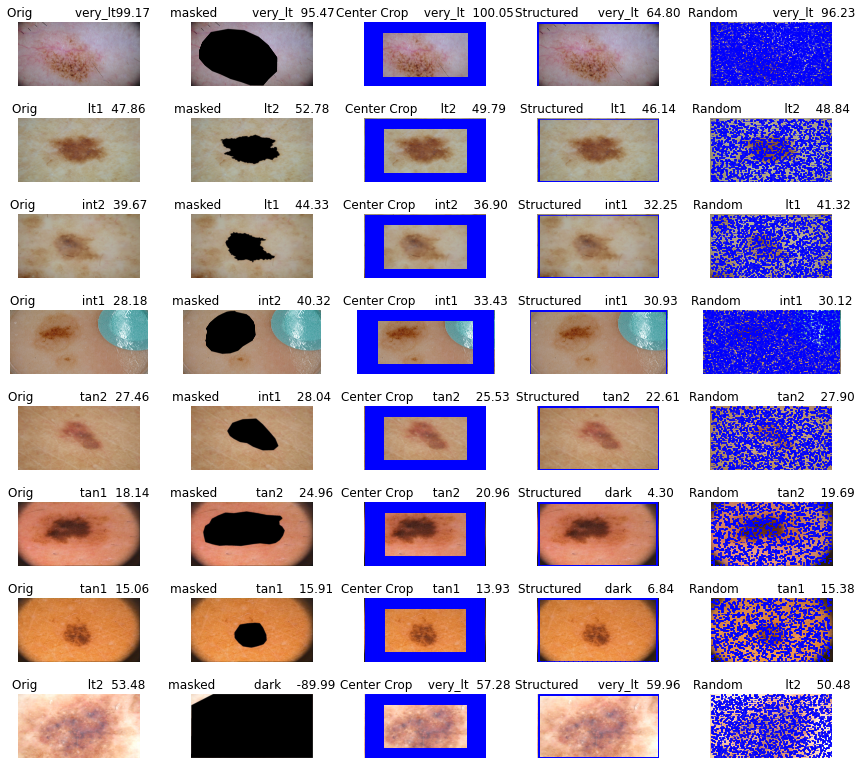

In [ ]:
ITA_Categories_list = ["dark", "tan1", "tan2", "int1", "int2", "lt1", "lt2", "very_lt"]
ITA_Categories_list.reverse()
        
plt.figure(figsize=(15, 70))
index = 0
display_image_count = 1
col_count = 5
for cat in ITA_Categories_list:
    cat_df = df[df["ITA_masked_category"] == cat]
    #print(cat_df.head())
    for ele in cat_df.head(display_image_count).iterrows():
        #print(ele[1])
        
        # Original
        ax = plt.subplot(8*col_count, col_count, index + 1)
        img = io.BytesIO(ele[1]["image"])
        plt.imshow(Image.open(img),aspect=.7)     
           
        title = f"{'Orig':15}{ele[1]['ITA_orig_category']:^7}{ele[1]['ITA_orig']:^3.2f}"
        plt.title(title)
        plt.axis("off")
        plt.subplots_adjust(hspace = .5)        
        index += 1

        # Masked
        ax = plt.subplot(8*col_count, col_count, index + 1)
        img = io.BytesIO(ele[1]["masked_image"])
        plt.imshow(Image.open(img),aspect=.7)        
        title = f"{'masked':15}{ele[1]['ITA_masked_category']:^7}  {ele[1]['ITA_masked']:^5.2f}"
        plt.title(title)
        plt.axis("off")
        plt.subplots_adjust(hspace = .5)
        index += 1

        # Center cropped
        ax = plt.subplot(8*col_count, col_count, index + 1)
        img = io.BytesIO(ele[1]["image"])
        plt.imshow(Image.open(img),aspect=.7)        
        title = f"{'Center Crop':15}{ele[1]['ITA_center_cropped_category']:^7}  {ele[1]['ITA_center_cropped']:^5.2f}"
        plt.title(title)
        plt.axis("off")
        plt.subplots_adjust(hspace = .5)            
        coords = ele[1]["ITA_center_cropped_indices"]
        for coord in coords:
            # Create a Rectangle patch    
            x = coord[0] * PATCH_WIDTH + BORDER_REMOVAL_SIZE
            y = int(coord[1] * PATCH_WIDTH) + BORDER_REMOVAL_SIZE    
            rect = patches.Rectangle((y, x), PATCH_HEIGHT, PATCH_WIDTH, linewidth=1, edgecolor='b', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)
        index += 1

        # Structured
        ax = plt.subplot(8*col_count, col_count, index + 1)
        img = io.BytesIO(ele[1]["image"])
        plt.imshow(Image.open(img),aspect=.7)        
        title = f"{'Structured':15}{ele[1]['ITA_structured_patches_category']:^7}  {ele[1]['ITA_structured_patches']:^5.2f}"
        plt.title(title)
        plt.axis("off")
        plt.subplots_adjust(hspace = .5)
        coords = ele[1]["ITA_structured_patches_indices"]
        for coord in coords:
            # Create a Rectangle patch    
            x = coord[0] * PATCH_WIDTH + BORDER_REMOVAL_SIZE
            y = int(coord[1] * PATCH_WIDTH) + BORDER_REMOVAL_SIZE    
            rect = patches.Rectangle((y, x), PATCH_HEIGHT, PATCH_WIDTH, linewidth=1, edgecolor='b', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)
        index += 1

        # Random
        ax = plt.subplot(8*col_count, col_count, index + 1)
        img = io.BytesIO(ele[1]["image"])
        plt.imshow(Image.open(img),aspect=.7)        
        title = f"{'Random':15}{ele[1][f'ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}_category']:^7}  {ele[1][f'ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}']:^5.2f}"
        plt.title(title)
        plt.axis("off")
        plt.subplots_adjust(hspace = .5)
        coords = ele[1][f"ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}_indices"]
        for coord in coords:
            # Create a Rectangle patch    
            x = coord[0] * PATCH_WIDTH + BORDER_REMOVAL_SIZE
            y = int(coord[1] * PATCH_WIDTH) + BORDER_REMOVAL_SIZE    
            rect = patches.Rectangle((y, x), PATCH_HEIGHT, PATCH_WIDTH, linewidth=1, edgecolor='b', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)
        index += 1


        #TODO - create columns for smart random


# Evaluate ITA

(-50.0, 100.0)

<Figure size 360x720 with 0 Axes>

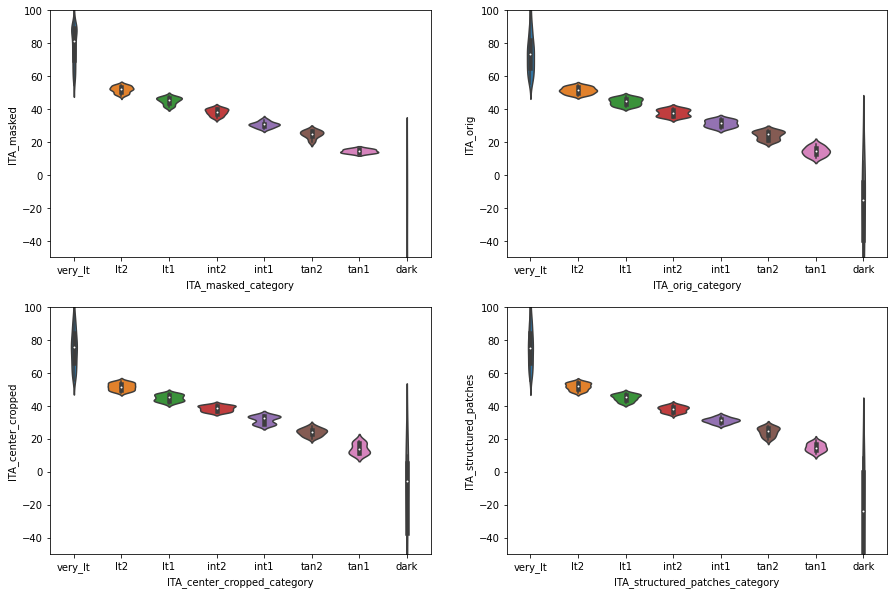

In [ ]:
catagories_to_test = ["ITA_orig", "ITA_center_cropped", "ITA_structured_patches", "ITA_random_patches"]
plt.figure(figsize=(5, 10))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

ax = sns.violinplot(data=df, y="ITA_masked", x="ITA_masked_category", order=ITA_Categories_list,ax=axes[0,0])
ax.set_ylim(-50,100)

ax = sns.violinplot(data=df, y="ITA_orig", x="ITA_orig_category", order=ITA_Categories_list,ax=axes[0,1])
ax.set_ylim(-50,100)

ax = sns.violinplot(data=df, y="ITA_center_cropped", x="ITA_center_cropped_category", order=ITA_Categories_list,ax=axes[1,0])
ax.set_ylim(-50,100)

ax = sns.violinplot(data=df, y="ITA_structured_patches", x="ITA_structured_patches_category", order=ITA_Categories_list,ax=axes[1,1])
ax.set_ylim(-50,100)


(-120.0, 100.0)

<Figure size 720x720 with 0 Axes>

<Figure size 360x720 with 0 Axes>

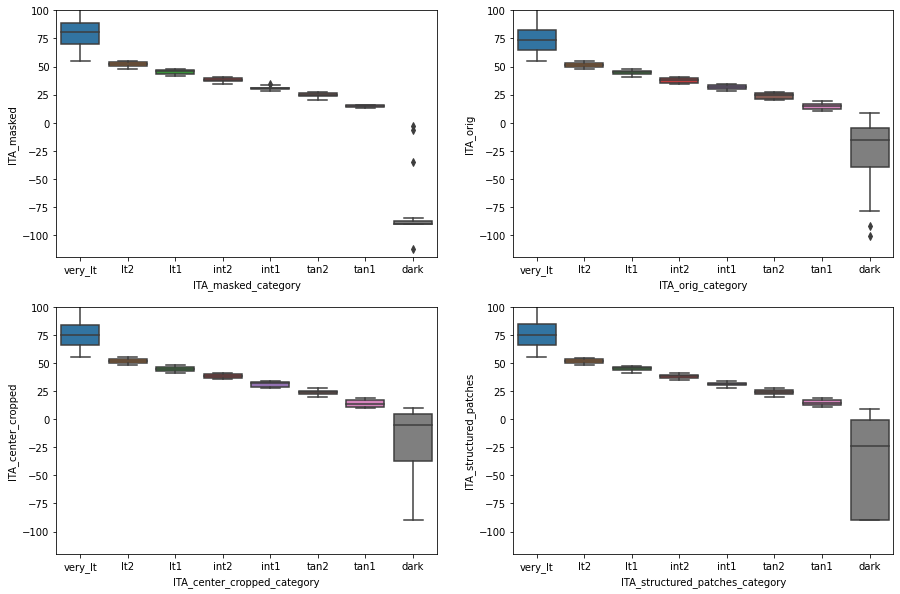

In [ ]:
plt.figure(figsize=(10, 10))

plt.figure(figsize=(5, 10))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

ax = sns.boxplot(data=df, y="ITA_masked", x="ITA_masked_category", order=ITA_Categories_list,ax=axes[0,0])
ax.set_ylim(-120,100)

ax = sns.boxplot(data=df, y="ITA_orig", x="ITA_orig_category", order=ITA_Categories_list,ax=axes[0,1])
ax.set_ylim(-120,100)

ax = sns.boxplot(data=df, y="ITA_center_cropped", x="ITA_center_cropped_category", order=ITA_Categories_list,ax=axes[1,0])
ax.set_ylim(-120,100)

ax = sns.boxplot(data=df, y="ITA_structured_patches", x="ITA_structured_patches_category", order=ITA_Categories_list,ax=axes[1,1])
ax.set_ylim(-120,100)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 87.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 74.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 57.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 54.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 52.6% of the points cannot be placed; y

(-120.0, 100.0)

<Figure size 1080x720 with 0 Axes>

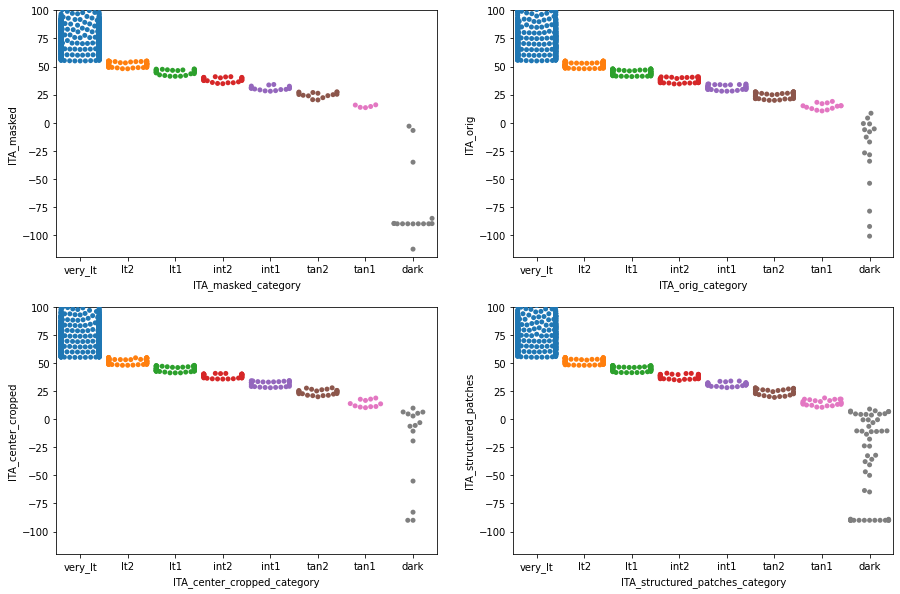

In [ ]:
plt.figure(figsize=(15, 10))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

ax = sns.swarmplot(data=df, y="ITA_masked", x="ITA_masked_category", order=ITA_Categories_list,ax=axes[0,0])
ax.set_ylim(-120,100)

ax = sns.swarmplot(data=df, y="ITA_orig", x="ITA_orig_category", order=ITA_Categories_list,ax=axes[0,1])
ax.set_ylim(-120,100)

ax = sns.swarmplot(data=df, y="ITA_center_cropped", x="ITA_center_cropped_category", order=ITA_Categories_list,ax=axes[1,0])
ax.set_ylim(-120,100)

ax = sns.swarmplot(data=df, y="ITA_structured_patches", x="ITA_structured_patches_category", order=ITA_Categories_list,ax=axes[1,1])
ax.set_ylim(-120,100)

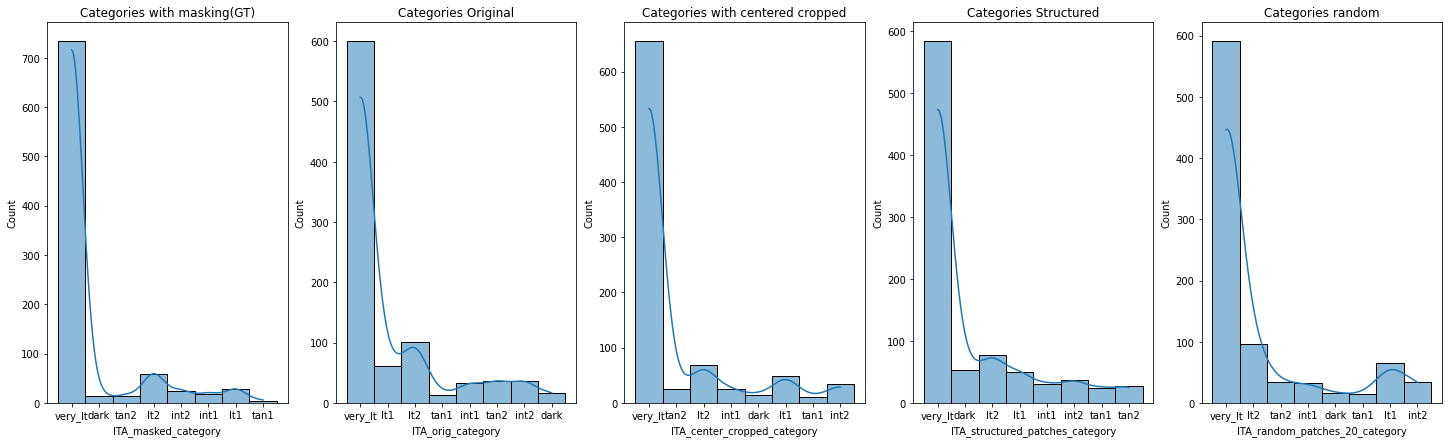

In [ ]:
f, axes = plt.subplots(1, 5)
f.set_size_inches(25,7)

ax = sns.histplot(df.ITA_masked_category,kde=True,ax=axes[0]).set_title("Categories with masking(GT)")
ax = sns.histplot(df.ITA_orig_category,kde=True,ax=axes[1]).set_title("Categories Original")
ax = sns.histplot(df.ITA_center_cropped_category,kde=True,ax=axes[2]).set_title("Categories with centered cropped")
ax = sns.histplot(df.ITA_structured_patches_category,kde=True,ax=axes[3]).set_title("Categories Structured")
ax = sns.histplot(df.ITA_random_patches_20_category,kde=True,ax=axes[4]).set_title("Categories random")

## Performance metrics

Table 3: Evaluation metrics of skin tone predictions compared to manually annotated ground-truth. Metrics are  MAE: mean absolute error;
MSE: mean squared error; and rMSE: root mean squared
error.

Here is a list of other metrics we can look at https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [ ]:
def compute_metrics(df, column):
    results = {}
    drop_indexes =  np.where(np.isnan(df[column]))[0]
    df_masked_updated = df.ITA_masked.drop(drop_indexes)
    df_column_updated = df[column].drop(drop_indexes)
    results["Root Mean Squared Error"] = mean_squared_error(df_masked_updated, df_column_updated, squared=False)
    results["Mean Absolute Error"] = mean_absolute_error(df_masked_updated, df_column_updated)
    results["Max error"] = max_error(df_masked_updated, df_column_updated)
    results["Mean Squared Error"] = mean_squared_error(df_masked_updated, df_column_updated)    
    results["Explained Variance Score"] = explained_variance_score(df_masked_updated, df_column_updated)
    results["R^2 Score"] = r2_score(df_masked_updated, df_column_updated)
    
    # Cant do the following because there are negative values in ITA and these metrics dont support negative values
    # 
    #results["Mean Squared Log Error"] = mean_squared_log_error(df_masked_updated, df_column_updated)
    #results["Mean Poisson Deviance"] = mean_poisson_deviance(df_masked_updated, df_column_updated)
    #results["Mean Gamma Deviance"] = mean_gamma_deviance(df_masked_updated, df_column_updated)
    #results["Mean Tweedie Deviance"] = mean_tweedie_deviance(df_masked_updated, df_column_updated)

    return results

In [ ]:
# evaluating using mean squared error
# as part of the ITA calculation some rows could not compute the ITA value. 
# We will do some preprocess to drop those rows
catagories_to_test = ["ITA_orig", "ITA_center_cropped", "ITA_structured_patches", f"ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}"]

printed_header = False
for cat in catagories_to_test:
    results = compute_metrics(df,cat)
    if not printed_header:
        print_str = f"|{'Approach':^25}|"
        for key, val in results.items():
            print_str +=f"{key:^25}|"
        print(print_str)
        printed_header = True

    print_str = f"|{cat:25}|"
    for key, val in results.items():
        print_str += f"{val:^25.3f}|"
    print(print_str)


|        Approach         | Root Mean Squared Error |   Mean Absolute Error   |        Max error        |   Mean Squared Error    |Explained Variance Score |        R^2 Score        |
|ITA_orig                 |         21.897          |         10.998          |         146.314         |         479.500         |          0.459          |          0.372          |
|ITA_center_cropped       |         17.431          |          7.817          |         147.277         |         303.854         |          0.595          |          0.562          |
|ITA_structured_patches   |         31.952          |         14.724          |         219.448         |        1020.931         |         -0.286          |         -0.474          |
|ITA_random_patches_20    |         21.882          |         10.661          |         148.545         |         478.836         |          0.408          |          0.309          |


## Confusion matrix of labels

In [ ]:
df.head()

,ID,image,mask,masked_image,ITA_masked,ITA_orig,ITA_center_cropped,ITA_center_cropped_indices,ITA_structured_patches,ITA_structured_patches_indices,ITA_random_patches_20,ITA_random_patches_20_indices,ITA_orig_category,ITA_masked_category,ITA_center_cropped_category,ITA_structured_patches_category,ITA_random_patches_20_category
0,ISBI2016_ISIC_Part1_Training/ISIC_0000395,b'\xff\xd8\xff\xdb\x00C\x00\x05\x03\x04\x04\x0...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,95.472412,99.173604,100.053415,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",64.795851,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",96.228664,"[[0, 1], [0, 2], [0, 8], [0, 10], [0, 18], [0,...",very_lt,very_lt,very_lt,very_lt,very_lt
1,ISBI2016_ISIC_Part1_Training/ISIC_0010322,b'\xff\xd8\xff\xdb\x00C\x00\x02\x01\x01\x01\x0...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,89.962484,42.457816,60.018109,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",58.318600,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",49.092572,"[[0, 1], [0, 3], [0, 6], [0, 13], [0, 14], [0,...",lt1,very_lt,very_lt,very_lt,lt2
2,ISBI2016_ISIC_Part1_Training/ISIC_0010204,b'\xff\xd8\xff\xdb\x00C\x00\x02\x01\x01\x01\x0...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,-89.993605,53.479097,57.283772,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",59.959701,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",50.483603,"[[0, 11], [0, 14], [0, 22], [0, 25], [0, 26], ...",lt2,dark,very_lt,very_lt,lt2
3,ISBI2016_ISIC_Part1_Training/ISIC_0009919,b'\xff\xd8\xff\xdb\x00C\x00\x08\x06\x06\x07\x0...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,84.267567,81.150671,82.840260,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",81.280333,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",81.185272,"[[0, 1], [0, 3], [0, 4], [0, 20], [0, 26], [0,...",very_lt,very_lt,very_lt,very_lt,very_lt
4,ISBI2016_ISIC_Part1_Training/ISIC_0000322,b'\xff\xd8\xff\xdb\x00\x84\x00\x02\x02\x02\x02...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,24.963917,18.135162,20.957648,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",4.300043,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",19.692814,"[[0, 8], [0, 11], [0, 12], [0, 27], [0, 29], [...",tan1,tan2,tan2,dark,tan2


<Figure size 1008x1008 with 0 Axes>

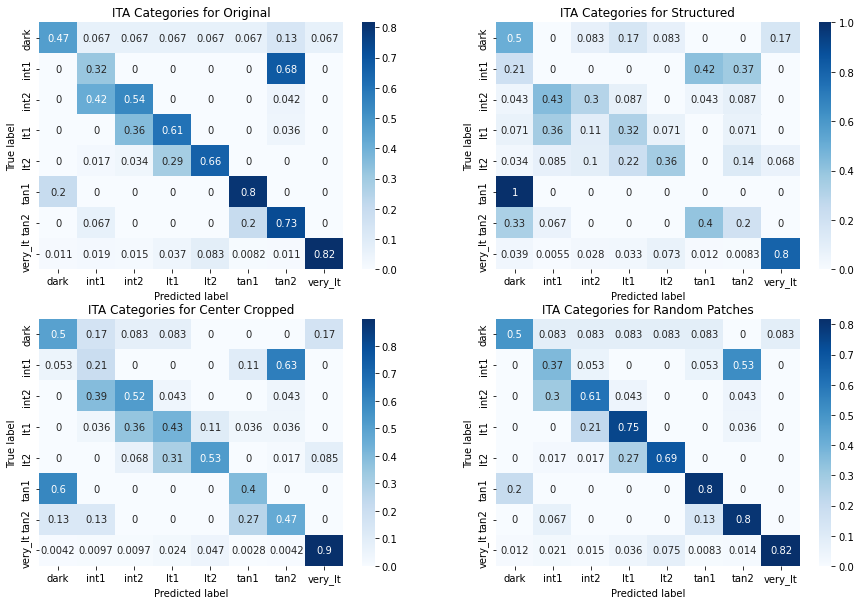

In [ ]:
plt.figure(figsize=(14, 14))
cols = 2
rows = 2
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,10))

plot_titles = ["ITA Categories for Original", "ITA Categories for Center Cropped", "ITA Categories for Structured", "ITA Categories for Random Patches"]

for index, cat in enumerate(catagories_to_test):
    
    category = f"{cat}_category"    
    
    drop_indexes =  np.where(np.isnan(df[cat]))[0]
    df_masked_updated = df.ITA_masked_category.drop(drop_indexes)
    df_column_updated = df[category].drop(drop_indexes)
    cm = confusion_matrix(df_masked_updated,df_column_updated,normalize="true")
    df_cm = pd.DataFrame(cm,columns=np.unique(df.ITA_masked_category.to_numpy()),index=np.unique(df.ITA_masked_category.to_numpy()))
    col = index % cols
    row = int(index/rows)
    ax = sns.heatmap(df_cm, annot=True,cmap="Blues",ax=axes[col,row])
    ax.set_title(plot_titles[index])
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')


In [ ]:
cm